# Testing Xception

In [1]:
import tensorflow as tf
import data.imageReading as ir
from fairness import fairnessMetrics as fm
from model import model as m
from model import utils as utils
from model import biasMitigation as mit
from model import evaluation as ev
from tuning import callbacks as cb
import datetime
import os
import numpy as np

In [2]:
preprocess_input = tf.keras.applications.xception.preprocess_input

image_size = (299,299)
batch_size = 32
epochs = 20
#(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", image_size, batch_size, preprocess_input)
#(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace", image_size, batch_size, preprocess_input)
(ds_train, train_batches, ds_val, val_batches, ds_test, test_batches, count_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces_split", image_size, batch_size, preprocess_input, None, False, False)
(ffds_train, fftrain_batches, ffds_val, ffval_batches, ffds_test, fftest_batches, ffcount_classes) = ir.readData("/mimer/NOBACKUP/groups/snic2022-22-1091/FairFace_split", image_size, batch_size, preprocess_input, None, False, False)


options = tf.data.Options()
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF
ds_train = ds_train.with_options(options)
ds_val = ds_val.with_options(options)
ds_test = ds_test.with_options(options)

Found 3916 images belonging to 2 classes.
Found 489 images belonging to 2 classes.
Found 492 images belonging to 2 classes.
Count classes: (2052, 1864, 256, 233, 258, 234)
Found 78158 images belonging to 2 classes.
Found 9769 images belonging to 2 classes.
Found 9771 images belonging to 2 classes.
Count classes: (36736, 41422, 4592, 5177, 4592, 5179)


## Find learning rate

In [3]:
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (299,299), "Xception")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(), 
                           loss="binary_crossentropy", 
                           metrics="accuracy")


Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:ten

Epoch 1/200
10/10 - 21s - loss: 0.8381 - accuracy: 0.4812 - 21s/epoch - 2s/step
Epoch 2/200
10/10 - 5s - loss: 0.8519 - accuracy: 0.4844 - 5s/epoch - 452ms/step
Epoch 3/200
10/10 - 5s - loss: 0.8866 - accuracy: 0.4563 - 5s/epoch - 464ms/step
Epoch 4/200
10/10 - 4s - loss: 0.8524 - accuracy: 0.4969 - 4s/epoch - 445ms/step
Epoch 5/200
10/10 - 5s - loss: 0.8034 - accuracy: 0.5531 - 5s/epoch - 475ms/step
Epoch 6/200
10/10 - 5s - loss: 0.9018 - accuracy: 0.4437 - 5s/epoch - 467ms/step
Epoch 7/200
10/10 - 5s - loss: 0.8527 - accuracy: 0.4875 - 5s/epoch - 463ms/step
Epoch 8/200
10/10 - 5s - loss: 0.8126 - accuracy: 0.5344 - 5s/epoch - 455ms/step
Epoch 9/200
10/10 - 4s - loss: 0.7962 - accuracy: 0.5625 - 4s/epoch - 443ms/step
Epoch 10/200
10/10 - 5s - loss: 0.8256 - accuracy: 0.5094 - 5s/epoch - 453ms/step
Epoch 11/200
10/10 - 5s - loss: 0.8568 - accuracy: 0.5031 - 5s/epoch - 452ms/step
Epoch 12/200
10/10 - 5s - loss: 0.8698 - accuracy: 0.4875 - 5s/epoch - 455ms/step
Epoch 13/200
10/10 - 5s - 

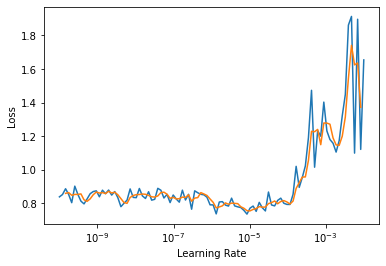

In [4]:
epochs = 200
train_input = []
train_output = []
nr_batches = 10

model.fit(ds_train, steps_per_epoch=nr_batches, callbacks=[cb.LerningRateCallback(100, nr_batches)], epochs=epochs, verbose=2)

## 5-Fold Cross Validation Xception without Transfer Learning (unweighted)

In [3]:
preprocess = tf.keras.applications.xception.preprocess_input
strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    history = ev.kfoldCrossValidation("/mimer/NOBACKUP/groups/snic2022-22-1091/museumFaces", m.build_model(False, (299,299), "Xception"), preprocess, 1e-4, (299,299), 5)

INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/device:CPU:0 then broadcast to ('/job:localhost/replica:0/task:0/device:CPU:0',).
INFO:tensorflow:Reduce to /job:localhost/replica:0/task:0/

/apps/Arch/software/TensorFlow/2.7.1-foss-2021b-CUDA-11.4.1/lib/python3.9/site-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


sc
Epoch 1/20
123/123 [==============================] - ETA: 0s - loss: 0.9817 - accuracy: 0.5959 - true_positives: 1075.0000 - true_negatives: 1252.0000 - false_positives: 770.0000 - false_negatives: 808.0000 - true_positive_rate: 0.5709 - true_negative_rate: 0.6192 - false_positive_rate: 0.3808 - false_negative_rate: 0.4291 - positive_predicted_value: 0.5827 - false_discovery_rate: 0.4173 - negative_predicted_value: 0.6078 - false_omission_rate: 0.3922 - binary_demographic_parity_diff: -215.0000 - demographic_parity: 1845.0000 - binary_equalized_odds_diff: 0.0483 - binary_proportional_parity_diff: -0.0551 - proportional_parity: 0.4725 - binary_predictive_rate_parity_diff: -0.0251 - predictive_rate_parity: 0.5827 - binary_accuracy_parity_diff: 0.1918 - accuracy_parity: 0.5959 - false_negative_rate_parity_diff: -0.0483 - false_positive_rate_parity_diff: 0.0483 - binary_negative_predictive_rate_parity_diff: 0.0251 - negative_predictive_rate_parity: 0.5827 - binary_specificity_parity_di

2022-12-06 22:56:08.958010: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648000 exceeds 10% of free system memory.


123/123 [==============================] - 128s 732ms/step - loss: 0.9817 - accuracy: 0.5959 - true_positives: 1075.0000 - true_negatives: 1252.0000 - false_positives: 770.0000 - false_negatives: 808.0000 - true_positive_rate: 0.5709 - true_negative_rate: 0.6192 - false_positive_rate: 0.3808 - false_negative_rate: 0.4291 - positive_predicted_value: 0.5827 - false_discovery_rate: 0.4173 - negative_predicted_value: 0.6078 - false_omission_rate: 0.3922 - binary_demographic_parity_diff: -215.0000 - demographic_parity: 1845.0000 - binary_equalized_odds_diff: 0.0483 - binary_proportional_parity_diff: -0.0551 - proportional_parity: 0.4725 - binary_predictive_rate_parity_diff: -0.0251 - predictive_rate_parity: 0.5827 - binary_accuracy_parity_diff: 0.1918 - accuracy_parity: 0.5959 - false_negative_rate_parity_diff: -0.0483 - false_positive_rate_parity_diff: 0.0483 - binary_negative_predictive_rate_parity_diff: 0.0251 - negative_predictive_rate_parity: 0.5827 - binary_specificity_parity_diff: -0

2022-12-06 22:57:29.096112: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648000 exceeds 10% of free system memory.


123/123 [==============================] - 79s 644ms/step - loss: 0.5530 - accuracy: 0.7252 - true_positives: 1312.0000 - true_negatives: 1520.0000 - false_positives: 524.0000 - false_negatives: 549.0000 - true_positive_rate: 0.7050 - true_negative_rate: 0.7436 - false_positive_rate: 0.2564 - false_negative_rate: 0.2950 - positive_predicted_value: 0.7146 - false_discovery_rate: 0.2854 - negative_predicted_value: 0.7347 - false_omission_rate: 0.2653 - binary_demographic_parity_diff: -233.0000 - demographic_parity: 1836.0000 - binary_equalized_odds_diff: 0.0386 - binary_proportional_parity_diff: -0.0597 - proportional_parity: 0.4702 - binary_predictive_rate_parity_diff: -0.0201 - predictive_rate_parity: 0.7146 - binary_accuracy_parity_diff: 0.4504 - accuracy_parity: 0.7252 - false_negative_rate_parity_diff: -0.0386 - false_positive_rate_parity_diff: 0.0386 - binary_negative_predictive_rate_parity_diff: 0.0201 - negative_predictive_rate_parity: 0.7146 - binary_specificity_parity_diff: -0.

2022-12-06 22:58:48.004698: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648000 exceeds 10% of free system memory.


123/123 [==============================] - 80s 652ms/step - loss: 0.4342 - accuracy: 0.7944 - true_positives: 1427.0000 - true_negatives: 1675.0000 - false_positives: 379.0000 - false_negatives: 424.0000 - true_positive_rate: 0.7709 - true_negative_rate: 0.8155 - false_positive_rate: 0.1845 - false_negative_rate: 0.2291 - positive_predicted_value: 0.7901 - false_discovery_rate: 0.2099 - negative_predicted_value: 0.7980 - false_omission_rate: 0.2020 - binary_demographic_parity_diff: -293.0000 - demographic_parity: 1806.0000 - binary_equalized_odds_diff: 0.0445 - binary_proportional_parity_diff: -0.0750 - proportional_parity: 0.4625 - binary_predictive_rate_parity_diff: -0.0079 - predictive_rate_parity: 0.7901 - binary_accuracy_parity_diff: 0.5887 - accuracy_parity: 0.7944 - false_negative_rate_parity_diff: -0.0445 - false_positive_rate_parity_diff: 0.0445 - binary_negative_predictive_rate_parity_diff: 0.0079 - negative_predictive_rate_parity: 0.7901 - binary_specificity_parity_diff: -0.

2022-12-06 23:00:08.110217: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648000 exceeds 10% of free system memory.


123/123 [==============================] - 79s 642ms/step - loss: 0.3605 - accuracy: 0.8407 - true_positives: 1511.0000 - true_negatives: 1772.0000 - false_positives: 312.0000 - false_negatives: 310.0000 - true_positive_rate: 0.8298 - true_negative_rate: 0.8503 - false_positive_rate: 0.1497 - false_negative_rate: 0.1702 - positive_predicted_value: 0.8289 - false_discovery_rate: 0.1711 - negative_predicted_value: 0.8511 - false_omission_rate: 0.1489 - binary_demographic_parity_diff: -259.0000 - demographic_parity: 1823.0000 - binary_equalized_odds_diff: 0.0205 - binary_proportional_parity_diff: -0.0663 - proportional_parity: 0.4668 - binary_predictive_rate_parity_diff: -0.0223 - predictive_rate_parity: 0.8289 - binary_accuracy_parity_diff: 0.6814 - accuracy_parity: 0.8407 - false_negative_rate_parity_diff: -0.0205 - false_positive_rate_parity_diff: 0.0205 - binary_negative_predictive_rate_parity_diff: 0.0223 - negative_predictive_rate_parity: 0.8289 - binary_specificity_parity_diff: -0.

2022-12-06 23:01:30.670138: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648000 exceeds 10% of free system memory.


123/123 [==============================] - 83s 676ms/step - loss: 0.2905 - accuracy: 0.8840 - true_positives: 1633.0000 - true_negatives: 1819.0000 - false_positives: 214.0000 - false_negatives: 239.0000 - true_positive_rate: 0.8723 - true_negative_rate: 0.8947 - false_positive_rate: 0.1053 - false_negative_rate: 0.1277 - positive_predicted_value: 0.8841 - false_discovery_rate: 0.1159 - negative_predicted_value: 0.8839 - false_omission_rate: 0.1161 - binary_demographic_parity_diff: -211.0000 - demographic_parity: 1847.0000 - binary_equalized_odds_diff: 0.0224 - binary_proportional_parity_diff: -0.0540 - proportional_parity: 0.4730 - binary_predictive_rate_parity_diff: 2.6858e-04 - predictive_rate_parity: 0.8841 - binary_accuracy_parity_diff: 0.7680 - accuracy_parity: 0.8840 - false_negative_rate_parity_diff: -0.0224 - false_positive_rate_parity_diff: 0.0224 - binary_negative_predictive_rate_parity_diff: -2.6858e-04 - negative_predictive_rate_parity: 0.8841 - binary_specificity_parity_d

KeyboardInterrupt: 

## Test Xception without Transfer Learning (unweighted) 

In [ ]:
epochs = 20
class_weight = mit.findClassWeights(train_batches)

strategy = tf.distribute.MirroredStrategy()

with strategy.scope():
    model = m.build_model(False, (299,299), "Xception")
    metric_list = m.metrics_list()

model.compile(optimizer=tf.keras.optimizers.Adam(1e-5), 
                           loss="binary_crossentropy", 
                           metrics=metric_list)


utils.train_model(model, epochs, ds_train, train_batches, ds_val, val_batches, None, False)

print("Make folder...")
dir_name = datetime.datetime.now().strftime("%Y%m%d_%H%M%S") + "_Xception_unweighted"
os.mkdir(dir_name)

utils.saveModel(model, dir_name + "/Xception_unweighted.h5")

Weight for class 0: 0.95
Weight for class 1: 1.05
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:GPU:0',)
sc
Epoch 1/20
123/123 [==============================] - 125s 758ms/step - loss: 0.7106 - accuracy: 0.5812 - true_positives_21: 1017.0000 - true_negatives_14: 1259.0000 - false_positives_17: 793.0000 - false_negatives_18: 847.0000 - true_positive_rate: 0.5456 - true_negative_rate: 0.6135 - false_positive_rate: 0.3865 - false_negative_rate: 0.4544 - positive_predicted_value: 0.5619 - false_discovery_rate: 0.4381 - negative_predicted_value: 0.5978 - false_omission_rate: 0.4022 - binary_demographic_parity_diff: -296.0000 - demographic_parity: 1810.0000 - binary_equalized_odds_diff: 0.0679 - binary_proportional_parity_diff: -0.0756 - proportional_parity: 0.4622 - binary_predictive_rate_parity_diff: -0.0359 - predictive_rate_parity: 0.5619 - binary_accuracy_parity_diff: 0.1624 - accuracy_parity: 0.5812 - false_negative_rate_parity_diff: -0.0

In [ ]:
test_predict, test_labels, dir_name = ev.testModel(model, ds_test, test_batches, dir_name)
ev.testModelWithThresholdChange(model, ds_val, val_batches, test_predict, test_labels, dir_name)